# Overfitting, Regularization, and Cross-validation

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from IPython.display import display,Markdown

In [2]:
plt.rcParams.update({'font.size':16,'figure.figsize':(12,10)})

In [3]:
# Create instance of these classes
linear_regression = LinearRegression()
lasso = Lasso(alpha=0.1,normalize=True)
ridge = Ridge(alpha=0.1,normalize=True)

## What if there is no true relationship at all in your data?

In [4]:
x = np.linspace(0,3,51) # 51 values from 0 to 3
np.random.seed(3) # Setting random seed for reproducability
y = np.random.normal(0,2,len(x)) # Pure noise
df = pd.DataFrame(np.column_stack([y,x]),columns=['Super Power Enhancement','Radiation Dose'])
df.head(10)

,Super Power Enhancement,Radiation Dose
0,3.577257,0.00
1,0.873020,0.06
2,0.192995,0.12
3,-3.726985,0.18
4,-0.554776,0.24
5,-0.709518,0.30
6,-0.165483,0.36
7,-1.254001,0.42
8,-0.087636,0.48
9,-0.954436,0.54


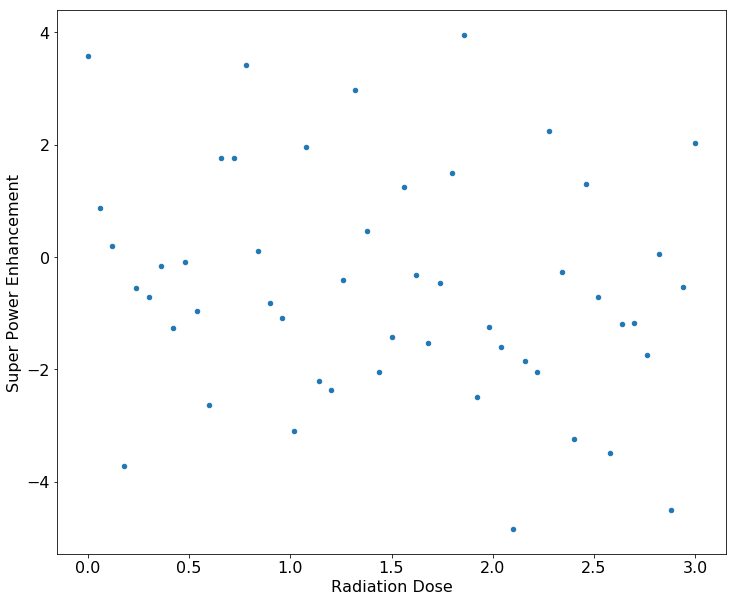

In [5]:
df.plot.scatter('Radiation Dose','Super Power Enhancement');

## You may still get non-zero coefficients

In [6]:
linear_regression.fit(df[['Radiation Dose']],df['Super Power Enhancement'])
m = linear_regression.coef_
b = linear_regression.intercept_
Markdown("## [Super Power Enhancment] = %.3g*[Radiation Dose] + %.3g" % (b,m))

## [Super Power Enhancment] = 0.146*[Radiation Dose] + -0.455

### One option is to just see if coefficients are "significant" and only keep them in the model if they are

In [7]:
X = sm.add_constant(df[['Radiation Dose']])
y = df['Super Power Enhancement']
model = sm.OLS(y, X)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Super Power Enhancement   R-squared:                       0.040
Model:                                 OLS   Adj. R-squared:                  0.020
Method:                      Least Squares   F-statistic:                     2.038
Date:                     Mon, 26 Mar 2018   Prob (F-statistic):              0.160
Time:                             00:15:23   Log-Likelihood:                -106.94
No. Observations:                       51   AIC:                             217.9
Df Residuals:                           49   BIC:                             221.7
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1456      0.555      0.263      0.794      -0.969       1.260
Radiation Dose    -0.4548      0.319     -1.428      0.160      -1.095       0.185
==============================================================================
Omnibus:                        0.718   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.698   Jarque-Bera (JB):                0.786
Skew:                           0.256   Prob(JB):                        0.675
Kurtosis:                       2.673   Cond. No.                         4.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## What if there is a true relationship in your data, but only for some variables?

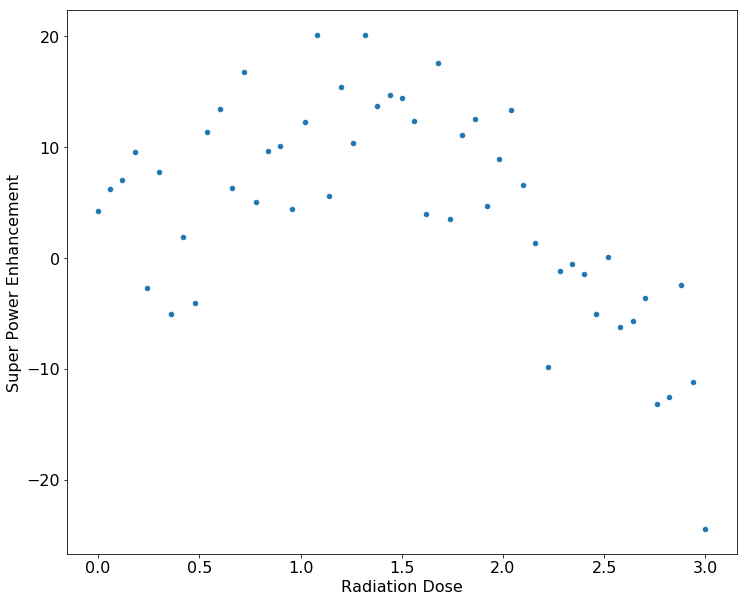

In [8]:
y = 12*x - 2*x**3 + np.random.normal(0,5,len(x))
df = pd.DataFrame(np.column_stack([y,x]),columns=['Super Power Enhancement','Radiation Dose'])
df.plot.scatter('Radiation Dose','Super Power Enhancement');

## Recall that we can add functions of variables that we already have to a dataframe 

In [9]:
df_poly = df.copy()
for i in range(2,4):
    df_poly['Radiation Dose ^ %d' % i] = df_poly['Radiation Dose']**i
df_poly.head()

,Super Power Enhancement,Radiation Dose,Radiation Dose ^ 2,Radiation Dose ^ 3
0,4.263989,0.00,0.0000,0.000000
1,6.260505,0.06,0.0036,0.000216
2,7.033497,0.12,0.0144,0.001728
3,9.586052,0.18,0.0324,0.005832
4,-2.739151,0.24,0.0576,0.013824


## Then we can fit using those functions (here, integer powers) of the variables

In [10]:
X = df_poly[['Radiation Dose','Radiation Dose ^ 2','Radiation Dose ^ 3']]
y = df_poly['Super Power Enhancement']
linear_regression.fit(X,y)
m = linear_regression.coef_
b = linear_regression.intercept_
Markdown("## $[Super Power Enhancement] = "+"+ ".join(["%.3g * [Radiation Dose]^%d "%(m[i],i+1) for i in range(3)])+"+ %.3g$"%b)

## $[Super Power Enhancement] = 14.4 * [Radiation Dose]^1 + -3.54 * [Radiation Dose]^2 + -1.12 * [Radiation Dose]^3 + 1.38$

## Hmmm, these don't look at all like the right values...

In [11]:
X = sm.add_constant(df_poly[['Radiation Dose','Radiation Dose ^ 2','Radiation Dose ^ 3']])
y = df['Super Power Enhancement']
model = sm.OLS(y, X)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Super Power Enhancement   R-squared:                       0.671
Model:                                 OLS   Adj. R-squared:                  0.650
Method:                      Least Squares   F-statistic:                     32.02
Date:                     Mon, 26 Mar 2018   Prob (F-statistic):           2.01e-11
Time:                             00:15:23   Log-Likelihood:                -158.14
No. Observations:                       51   AIC:                             324.3
Df Residuals:                           47   BIC:                             332.0
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.3804      2.919      0.473      0.639      -4.493       7.254
Radiation Dose        14.3543      8.512      1.686      0.098      -2.769      31.478
Radiation Dose ^ 2    -3.5370      6.630     -0.533      0.596     -16.876       9.802
Radiation Dose ^ 3    -1.1227      1.452     -0.773      0.443      -4.044       1.799
==============================================================================
Omnibus:                        1.220   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.543   Jarque-Bera (JB):                1.195
Skew:                          -0.344   Prob(JB):                        0.550
Kurtosis:                       2.703   Cond. No.                         160.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## None of the coefficients are significant, and the values aren't particularly accurate!  

# The Lasso
![lasso](http://www.virginia.gop/wp-content/uploads/lasso1.jpg)

## Regularization, Shrinkage

In [12]:
lasso = Lasso(alpha=2e-1,normalize=True,fit_intercept=False)
X = df_poly[['Radiation Dose','Radiation Dose ^ 2','Radiation Dose ^ 3']]
lasso.fit(X,y)
m = lasso.coef_
b = lasso.intercept_
Markdown("## $[Super Power Enhancement] = "+"+ ".join(["%.3g * [Radiation Dose]^%d "%(m[i],i+1) for i in range(3)])+"+ %.3g$"%b)

## $[Super Power Enhancement] = 11.8 * [Radiation Dose]^1 + -0 * [Radiation Dose]^2 + -2.01 * [Radiation Dose]^3 + 0$

## We (approximately) recovered the true model!  

## How does this work?

## The model
### $y = m*x_1 + m*x_2 + m*x_3 + noise$

### Normal regression minimizes:
$y - m*x_1 - m*x_2 - m*x_3 - ...$

### Lasso regression minimizes:
$y - m_1*x_1 - m_2*x_2 - m_3*x_3 + \alpha(|m_1|+|m_2|+|m_3|+...)$

#### There is a tradeoff between fitting the data well and having too many non-zero coefficients

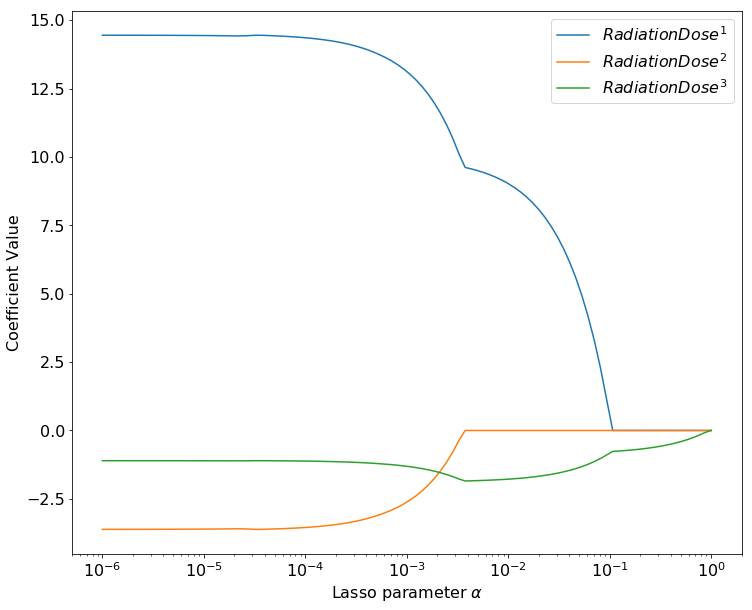

In [13]:
n = 100
coefs = np.empty((n,3))
alphas = np.logspace(-6,0,n)
for i,alpha in enumerate(alphas):
    lasso = Lasso(alpha=alpha,normalize=True)
    lasso.fit(X,y)
    coefs[i,:] = lasso.coef_
plt.plot(alphas,coefs)
plt.xscale('log')
plt.xlabel(r'Lasso parameter $\alpha$');
plt.ylabel('Coefficient Value');
plt.legend([r'$Radiation Dose^%d$' % i for i in range(1,4)]);

### Low values of $\alpha$ allow coefficients to (over)fit the data

### High values of $\alpha$ force coefficients to be zero (to be left out of the model)

## Cross-validation: Checking for overfitting

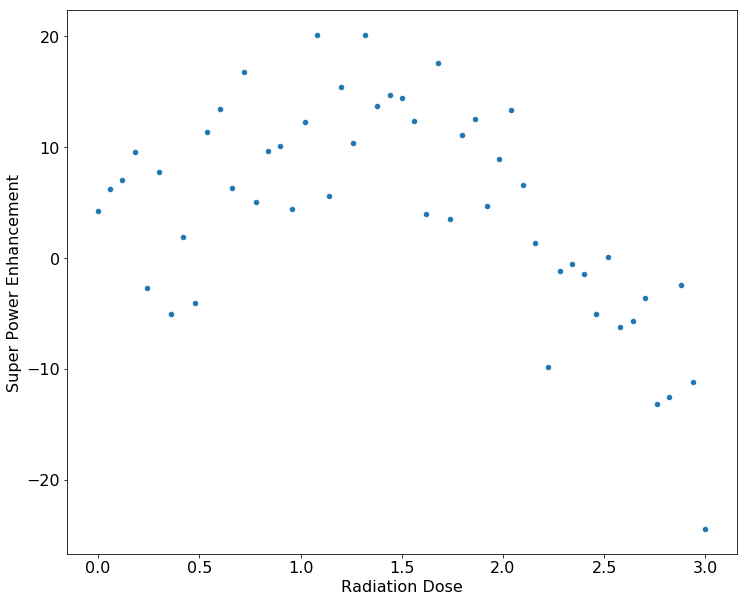

In [14]:
df.plot.scatter('Radiation Dose','Super Power Enhancement');

## Split the data into two groups

### One for fitting the model (training, in-sample)

### The other for checking the model fit (testing, out-of-sample)

In [15]:
df_test = df_poly.iloc[::3] # Every third value
df_train = df_poly[~df.index.isin(df_test.index)] # All the rest

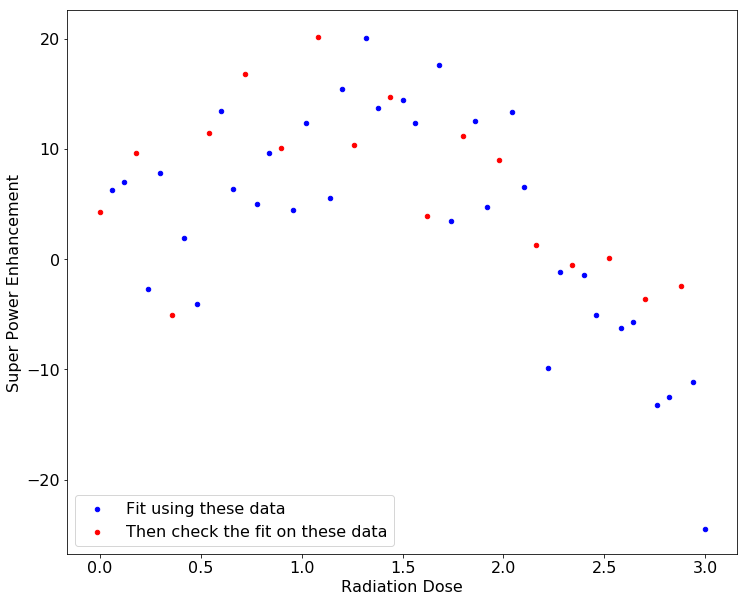

In [16]:
ax = df_train.plot.scatter('Radiation Dose','Super Power Enhancement',color='b');
df_test.plot.scatter('Radiation Dose','Super Power Enhancement',color='r',ax=ax);
plt.legend(['Fit using these data','Then check the fit on these data'])

In [17]:
def get_prediction(f,df_train,df_test):
    X_train = df_train.drop('Super Power Enhancement',axis=1)
    y_train = df_train['Super Power Enhancement']
    X_test = df_test.drop('Super Power Enhancement',axis=1)
    y_test = df_test['Super Power Enhancement']
    f.fit(X_train,y_train)
    predicted = f.predict(X_test)
    return predicted,y_test

## How well does the model predict the data that it wasn't fit on?  

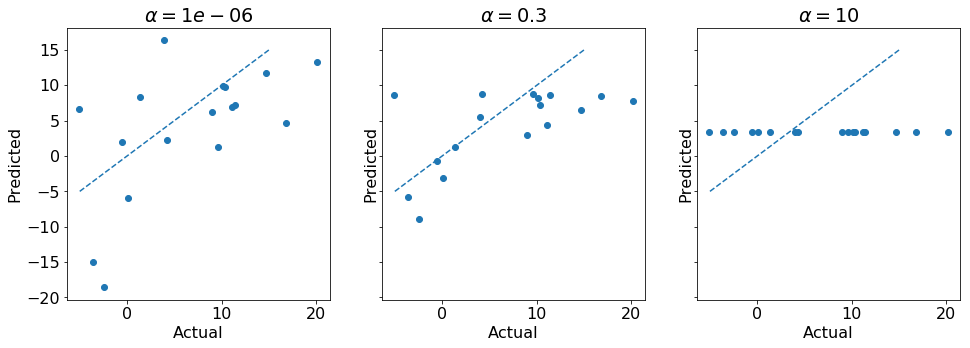

In [28]:
alphas = [1e-6,3e-1,1e1]
fig,axes = plt.subplots(1,3,sharey=True,figsize=(16,5))
for i,alpha in enumerate(alphas):
    ax = axes.flat[i]
    lasso = Lasso(alpha=alpha,normalize=True)
    predicted,actual = get_prediction(lasso,df_train,df_test)
    ax.scatter(actual,predicted)
    ax.set_title(r'$\alpha=%.2g$'%alpha)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.plot([-5,15],[-5,15],'--')

## We can show how the out-of-sample fit improves as the lasso is tightened

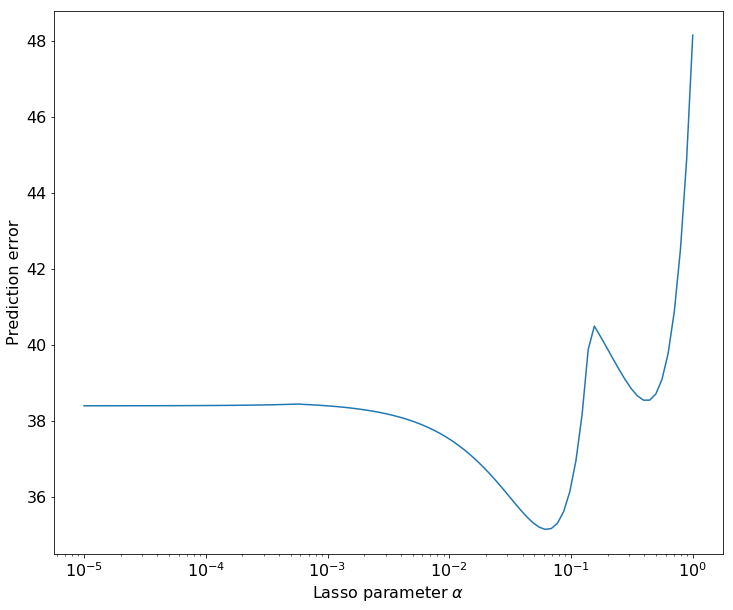

In [19]:
alphas = np.logspace(-5,0,100)
errors = np.empty(100)
for i,alpha in enumerate(alphas):
    lasso = Lasso(alpha=alpha,normalize=True)
    predicted,actual = get_prediction(lasso,df_train,df_test)
    errors[i] = np.mean((predicted-actual)**2)
plt.plot(alphas,errors)
plt.xscale('log')
plt.xlabel(r'Lasso parameter $\alpha$');
plt.ylabel('Prediction error');

## That seems like a small reduction in prediction error!

### - It's still worth it to recover the correct model

### - The error reduction will get *much* bigger as the number of parameters gets larger

## Let's add a bunch of new variables

### They won't be useful ones, but in general you wouldn't know that in advance

In [22]:
# Add random columns to the data frame
for i in range(10):
    df_poly[chr(65+i)] = np.random.rand(len(x))
X = df_poly.drop('Super Power Enhancement',axis=1)
y = df_poly['Super Power Enhancement']
df_test = df_poly.iloc[::3] # Every third value
df_train = df_poly[~df.index.isin(df_test.index)] # All the rest

In [23]:
df_train.head()

,Super Power Enhancement,Radiation Dose,Radiation Dose ^ 2,Radiation Dose ^ 3,A,B,C,D,E,F,G,H,I,J
1,6.260505,0.06,0.0036,0.000216,0.371980,0.290485,0.537434,0.013083,0.962923,0.834537,0.393541,0.244977,0.774447,0.462954
2,7.033497,0.12,0.0144,0.001728,0.597003,0.900711,0.995786,0.886484,0.359615,0.175501,0.913823,0.406102,0.851364,0.814124
4,-2.739151,0.24,0.0576,0.013824,0.227713,0.788832,0.302820,0.381825,0.447677,0.164475,0.748383,0.444468,0.749609,0.384735
5,7.775167,0.30,0.0900,0.027000,0.814782,0.895740,0.740813,0.978405,0.505597,0.015101,0.987510,0.503771,0.238480,0.291724
7,1.877398,0.42,0.1764,0.074088,0.410320,0.919821,0.746671,0.715882,0.977394,0.843947,0.284240,0.338177,0.329130,0.561289


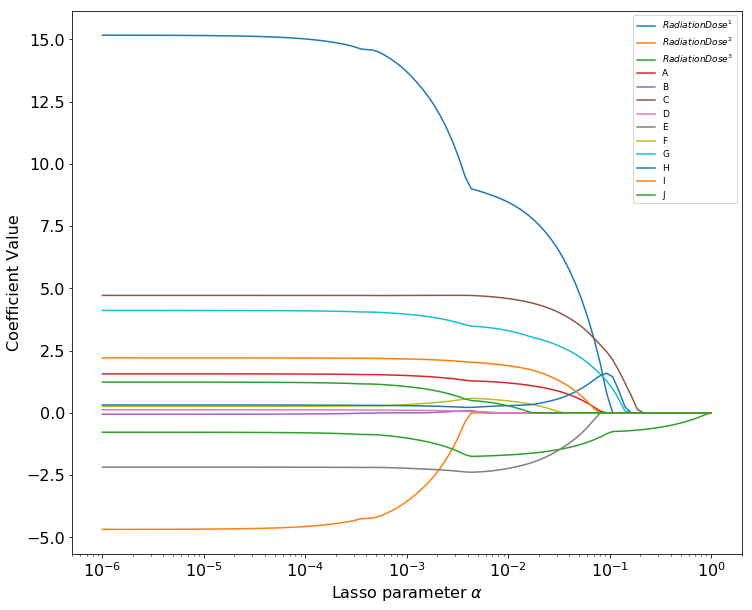

In [24]:
n = 100
coefs = np.empty((n,13))
alphas = np.logspace(-6,0,n)
for i,alpha in enumerate(alphas):
    lasso = Lasso(alpha=alpha,normalize=True)
    lasso.fit(X,y)
    coefs[i,:] = lasso.coef_
plt.plot(alphas,coefs)
plt.xscale('log')
plt.xlabel(r'Lasso parameter $\alpha$');
plt.ylabel('Coefficient Value');
plt.legend([r'$Radiation Dose^%d$' % i for i in range(1,4)]+[chr(65+i) for i in range(26)],fontsize=9);

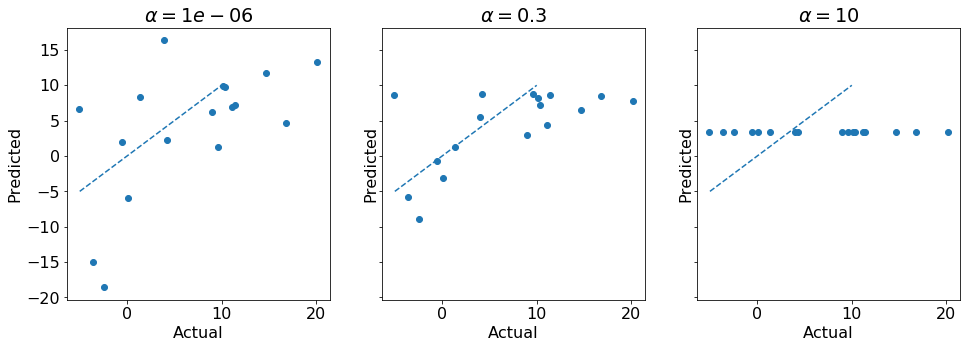

In [25]:
alphas = [1e-6,3e-1,1e1]
fig,axes = plt.subplots(1,3,sharey=True,figsize=(16,5))
for i,alpha in enumerate(alphas):
    ax = axes.flat[i]
    lasso = Lasso(alpha=alpha,normalize=True)
    predicted,actual = get_prediction(lasso,df_train,df_test)
    ax.scatter(actual,predicted)
    ax.set_title(r'$\alpha=%.2g$'%alpha)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.plot([-5,10],[-5,10],'--')

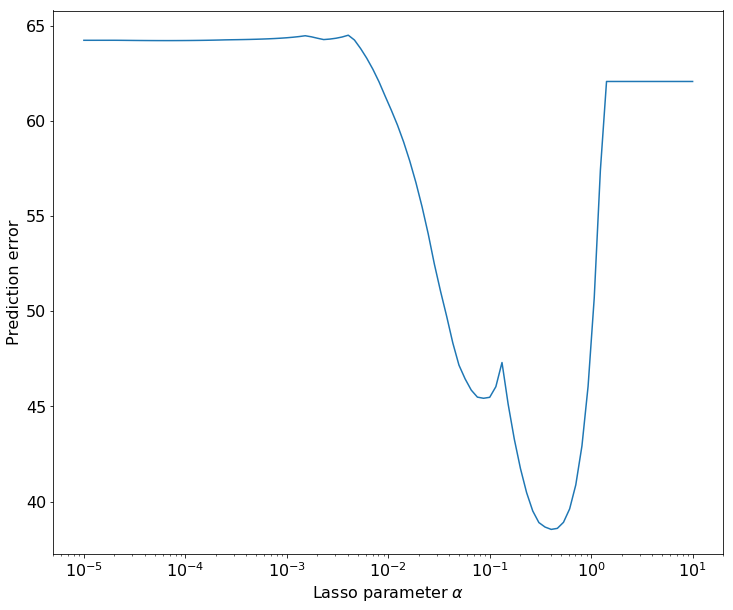

In [27]:
alphas = np.logspace(-5,1,100)
errors = np.empty(100)
for i,alpha in enumerate(alphas):
    lasso = Lasso(alpha=alpha,normalize=True)
    predicted,actual = get_prediction(lasso,df_train,df_test)
    errors[i] = np.mean((predicted-actual)**2)
plt.plot(alphas,errors)
plt.xscale('log')
plt.xlabel(r'Lasso parameter $\alpha$');
plt.ylabel('Prediction error');

## The reduction in out-of-sample prediction error from using the Lasso is now huge!